<a href="https://colab.research.google.com/github/khipu-ai/practicals-2019/blob/master/1b_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

© Deep Learning Indaba. Apache License 2.0.
Adaptado de [Khipu Practicals](https://khipu.ai/practicals/). 

## Introducción

En este notebook vamos a implementar algunos algoritmos de optimización (sin restricciones) para hallar el mínimo de la [Función de Rosenbrock](https://es.wikipedia.org/wiki/Funci%C3%B3n_de_Rosenbrock). Dicha función a es una función no convexa utilizada como problema de prueba del rendimiento para algoritmos de optimización.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
%matplotlib inline

display.clear_output()


$$ 
\newcommand{\vec}[1]{\mathbf{#1}}
\newcommand{\vechat}[1]{\hat{\mathbf{#1}}}
\newcommand{\x}{\vec{x}}
\newcommand{\utheta}{θ}
\newcommand{\th}{\vec{\utheta}}
\newcommand{\y}{\vec{y}}
\newcommand{\b}{\vec{b}}
\newcommand{\W}{\textrm{W}}
\newcommand{\L}{\mathcal{L}}
\newcommand{\xhat}{\vechat{x}}
\newcommand{\yhat}{\vechat{y}}
\newcommand{\bhat}{\vechat{b}}
\newcommand{\What}{\hat{\W}}
\newcommand{\partialfrac}[2]{\frac{\partial{#1}}{\partial{#2}}}
\newcommand{\ipartialfrac}[2]{{\partial{#1}}/{\partial{#2}}}
\newcommand{\dydx}{\partialfrac{\y}{\x}}
\newcommand{\dld}[1]{\partialfrac{\L}{#1}}
\newcommand{\dldx}{\dld{\x}}
\newcommand{\dldy}{\dld{\y}}
\newcommand{\dldw}{\dld{W}}
\newcommand{\idld}[1]{\ipartialfrac{\L}{#1}}
\newcommand{\idldx}{\idld{\x}}
\newcommand{\idldy}{\idld{\y}}
\newcommand{\idydx}{\ipartialfrac{\y}{\x}}
\newcommand{\red}[1]{\color{red}{#1}}
\newcommand{\green}[1]{\color{green}{#1}}
\newcommand{\blue}[1]{\color{blue}{#1}}
\newcommand{\because}[1]{&& \triangleright \textrm{#1}}
\newcommand{\relu}[1]{\textrm{relu}({#1})}
\newcommand{\step}[1]{\textrm{step}({#1})}
\newcommand{\gap}{\hspace{0.5mm}}
\newcommand{\gapp}{\hspace{1mm}}
\newcommand{\ngap}{\hspace{-0.5mm}}
\newcommand{\ngapp}{\hspace{-1mm}}
$$

## Función de Rosenbrock.
En la práctica lo que buscamos cuando evaluamos la performance de distintos algoritmos de optimización, nos importa la performance en un espectro amplio de problemas reales, por ejemplo la minimización de una función de pérdidas. Vamos a tomar como ejemplo de juguete la función de Rosenbrock, de forma tal de poder visualizar que está haciendo cada algoritmo. 

La función de Rosenbrock es una $f:\mathbb{R}^2\rightarrow \mathbb{R}, (x,y)\mapsto f(x,y)$, y se define como:

\begin{equation}
f(x,y) = (a-x)^2+b(y-x^2)^2
\end{equation}

donde valores tipicos para $a$ y $b$ son $1$ y $100$ respectivamente. Para esta práctica consideraremos $a=1$ y $b=20$. El mínimo global ocurre $(a, a^2)$ o, en este caso, $(1, 1)$. 


In [ ]:
def rosenbrock_banana(x, y, a=1., b=20.):
  return (a-x)**2 + b*(y-x**2)**2

# Visualicemos la función a través de sus curvas de nivel (*contour plot*)

In [ ]:
#@title Helper functions (RUN ME) (double click to unhide/hide the code)

def gen_2d_loss_surface(loss_func,
             n_x=100, # number of discretization points along the x-axis
             n_y=100, # number of discretization points along the x-axis
             min_x=-2., max_x=2., # extreme points in the x-axis
             min_y=-0.2, max_y=1.3 # extreme points in the y-axis
            ):
  
  # create a mesh of points at which to evaluate our function
  X, Y = np.meshgrid(np.linspace(min_x, max_x, n_x),
                     np.linspace(min_y, max_y, n_y))
  # evaluate the func at all of the points
  Z = loss_func(X, Y)
  
  return X, Y, Z
  
def make_contour_plot(X, Y, Z, levels=None):
  if levels == None:
    # generate 20 levels on a log scale
    levels = np.insert(np.logspace(0, 2.6, 20, True, base=10), 0, 0)
    
  fig = plt.figure(figsize=(9.84, 3))
  ax = fig.gca()
  
  ax.contour(X, Y, Z, levels, alpha=0.5)
  ax.contourf(X, Y, Z, levels, alpha=0.2)
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  
  return fig, ax

def make_surface_plot(X, Y, Z, elevation=0, azimuth_angle=0, levels=None):
  
  if levels == None:
    # generate 20 levels on a log scale
    levels = np.insert(np.logspace(0, 2.6, 20, True, base=10), 0, 0)
    
  fig = plt.figure(figsize=(10,6))
  ax = fig.gca(projection='3d')
  ax.view_init(elevation, azimuth_angle)
  ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.2)
  ax.contour(X, Y, Z, levels, cmap='viridis', alpha=0.5)
  
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  
  return fig, ax


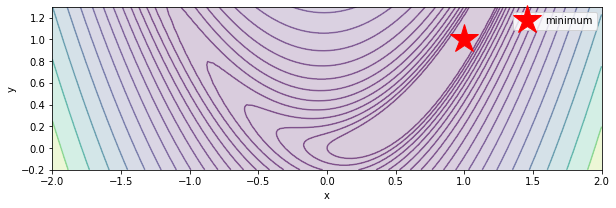

In [ ]:
X, Y, Z = gen_2d_loss_surface(rosenbrock_banana)
fig, ax = make_contour_plot(X, Y, Z)

# add a marker to show the minimum
ax.plot(1, 1, 'r*', ms=30, label='minimum') 
ax.legend()

fig.show()

Grafiquemos ahora la superficie en 3D (*surface plot*):
Observación: 
- elevation: ángulo de inclinación del eje $z$
- azhimuth angle: ángulo de rotación del plano $xy$


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


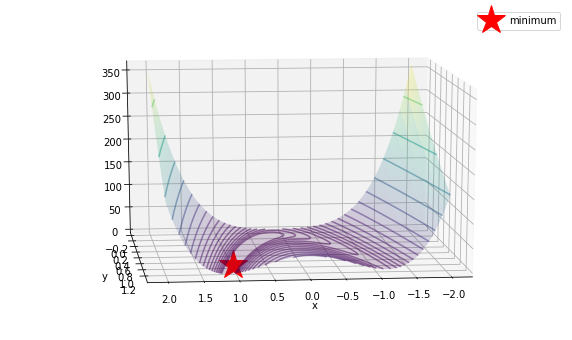

In [ ]:
#@title {run: "auto"}

elevation = 13 #@param {type:"slider", min:0, max:360, step:1}
azimuth_angle = 84 #@param {type:"slider", min:0, max:360, step:1}
  
X, Y, Z = gen_2d_loss_surface(rosenbrock_banana)
fig, ax = make_surface_plot(X, Y, Z, elevation, azimuth_angle)

ax.plot([1], [1], 'r*', zs=[0], zdir='z', ms=30, label='minimum')
ax.legend()

fig.show();

A veces se la llama funció *banana* porque la curva de nivel del valle tiene forma de  banana. Dentro de este valle se encuentra el mínimo global. Llegar al valle suele ser relativamente sencillo, pero encontrar el mínimo global es difícil, motivo por el cual se suele usar esta función para testear los algoritmos de optimización.

## Optimización

## Gradientes

### ¿Qué son los gradientes? 

*Nota:* esto es un repaso de la clase pasada, se puede saltear.

Comencemos un una función $f:\mathbb{R}\rightarrow \mathbb{R}, x\mapsto \green{f(x)}$

Podemos aproximar la función $\green f$ alrededor de un punto en particular  $x_0$ por la recta recta $\blue {d\ngap f}$:

$$\blue{d\ngap f(x)} = f(x_0) + \red{f'(x_0)}(x - x_0)$$


<center>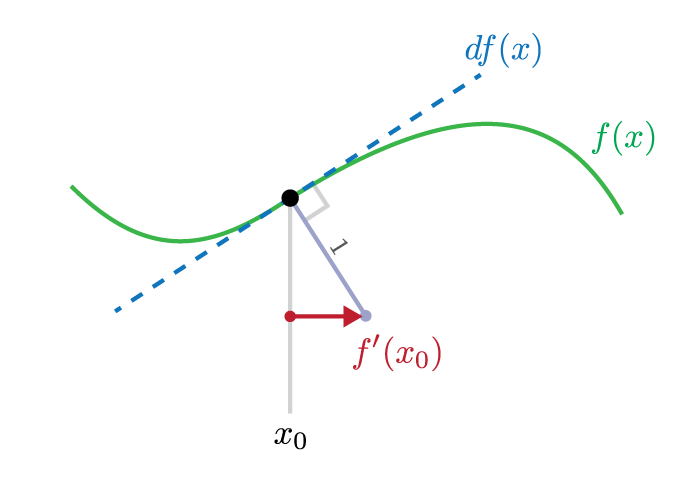</center>

Como muestra la imagen, podemos usar la derivada $f' = \frac{dy}{dx}$ para construir la mejor aproximación lineal de $f$ alrededor de $x_0$.

Observar que el gradiente  $\red{f'(x_0)}$ apunta siempre en la dirección de máximo crecimiento de $\green{f(x)}$, y su magnitud nos dice con que tasa lo hace.

### Yendo a más dimensiones


Algo similar ocurre cuando tenemos un campo escalar, es decir que $f:\mathbb{R}^n\rightarrow \mathbb{R},\quad n>0$. En este caso

$$\blue{d\hspace{-0.3ex}f(\x)} = f(\mathbf x_0) + \red{\nabla f(\mathbf x_0)}\gap\cdot \gap (\mathbf x - \mathbf x_0)$$

<center>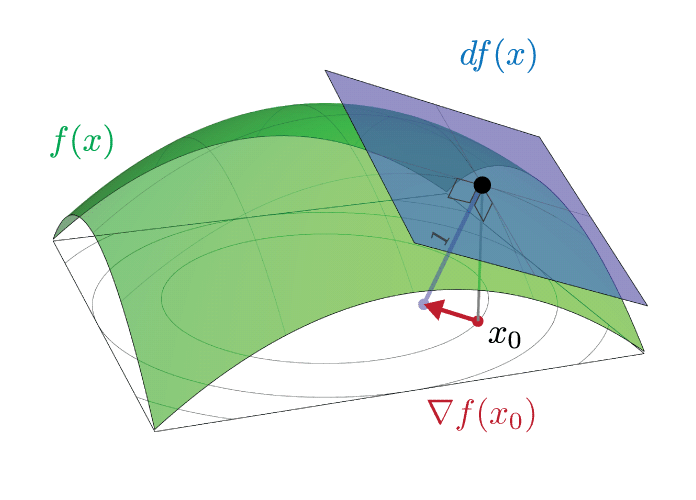</center>


El gradiente nos da la inclinación (pendiente) del plano que mejor aproxima a la superficie de $f$ alrededor de $x_0$. El gradiente apunta en la dirección de máximo crecimiento, y la magnitud nos habla de la tasa de dicho crecimiento.


## Gradient Descent

El método del gradiente descencdienes es de las formas más sencillas de entrenar algoritmos que se usan en deep learning. En muchos casos da muy buenos resultados, y sirve de base para introducir otros métods de optimización como Momentum, Adam, etc. Matemáticamente, el gradiente descendiente se puede describir como:

\begin{equation}
\mathbf{θ}= \mathbf{θ} −\eta \times \nabla_\mathbf{θ} L(\mathbf{θ})
\end{equation}

donde $\mathbf{θ}$ son los parámetros del modelo, $\eta$ es el paso, o la tasa de aprendizaje (learning rate), $L(\mathbf{θ})$ es la función de pérdida, y $\nabla_\theta L(\mathbf{θ})$ es el **gradiente** de la pérdida respecto de los parámetros. 

En la práctica, la tasa de aprendizaje $\eta$ es un hiper-parámetro más que se puede ajustar. 
Existen tres escenarios que vale la pena mecionar::

1.   Usar un *batch* de tamaño $N$, donde $N$ es la cantidad total de muestras,se conoce como **Batch Gradient Descent (BGD)**. En este caso, se calcul el gradiente sobre todas las muestras en cada iteración (es lo que vimos como Gradiente Descendiente en las diapositivas). Esto nos da una estimación del gradiente más *precisa*. Si la $\eta$ no es demasiado grande, se garantiza que BGD converge a:
    * el máximo global si la función es convexa,
    * un mínimo local si no es convexa (en caso que no haya [puntos de ensilladura](https://es.wikipedia.org/wiki/Punto_de_silla).
    
    La desventaja con BGD es que no es compatible con *online learning* (se van teniendo nuevos datos durante el entrenamiento), y puede ser muy lento para sets de entrenamiento muy grandes.

2.   Usar un *batch* de tamño 1, llamado **Stochastic Gradient Descent (SGD)**. En este caso, se usa un único punto del set de entrenamiento para calcular la estimación del gradiente. La esimación sigue siendo insesgada, pero resulta muy ruidosa, y no nos garantziza que hallemos un mímino. Sin embargo, funciona bien en la práctica.  Resulta que tener estiaciones ruidosas del grafiente funciona como regularización y previene *overfitting*. Además necesita mucha menos memoria para hacer el cálculo del gradiente. 

3.  Usar un *batch* de tamaño $M< N$  se llama **Mini-batch Gradient Descent** y es un compromiso entre BGD y SGD. En este caso, se usan $M$ muestras para estimar el gradiente. De esta forma, tenemos una estimación ruidosa del gradiente, pero con menos ruido que en SGD, y podemos optimizar el valor de $M$ para tener un buen uso de memoria, y la varianza del gradiente se reduce mucho, llevando a una mejor convergencia al mínimo.




### Opcional: cómo elegir el tamaño de batch.



Un enfoque es elegir el tamaño de batch lo más grande posible. Si tenemos acceso a hardware como GPUs que están optimizadas para hacer cómputos en paralelo entrenar con un batch más grande puede ser más rápido. En la práctica muchas veces se elige el tamaño de batch más grande que entre en memoria.

Además como al aumentar el tamaño del batch la estimación del gradiente es más precisa, podemos elegir un $\eta$ más grande, de forma que se converga en menor cantidad de iteraciones. Por otra parte, elegimos una tasa de aprendizaje muy grad puede resultar computacionalmente muy costoso e incluso no converger. En la práctica se [tunea](https://arxiv.org/pdf/1803.09820.pdf) la combinación de tamaño de batch y tasa de aprendizaje. 


Analicemos esto con un ejemplo unidimensional. En el gráfico de abajo se muestra una función $\green{f(x)}$, la verdadera recta tangente $\blue{df(x)}$, el verdadero gradiente $\blue{\tilde{f'}(x_0)}$, la recta tangente estimada $\red{\tilde{df}(x)}$ y el gradiente estimado $\red{\tilde{f'}(x_0)}$. 


In [ ]:
#@title Helper functions (RUN ME) (double click to unhide/hide the code)
def f(x):
  return -np.cos(x)

def tangent_f(x):
  return np.sin(x)

def df(x, x_0):
  return tangent_f(x_0) * (x - x_0) + f(x_0)

def perpindicular_unit_f(x_0):
  slope_f = tangent_f(x_0)
  y_0 = f(x_0)
  
  x_1 = slope_f / np.sqrt(2) + x_0
  y_1 = -x_1 / slope_f + y_0 + x_0 / slope_f
  
  return [[x_0, x_1], [y_0, y_1]]

def noisy_df(x, x_0, noisy_x_0):
  return tangent_f(noisy_x_0) * (x - x_0) + f(x_0)

def noisy_perpindicular_unit_f(x_0, noisy_x_0):
  slope_f = tangent_f(noisy_x_0)
  y_0 = f(x_0)
  
  x_1 = slope_f / np.sqrt(2) + x_0
  y_1 = -x_1 / slope_f + y_0 + x_0 / slope_f
  
  return [[x_0, x_1], [y_0, y_1]]

def interactive_noisy_gradient_visual(x_0, noisy_x_0):
  # change the fontsize for better visibility
  init_size = plt.rcParams["font.size"] # store initial font size
  plt.rcParams.update({'font.size': 22}) # update the size
  
  plt.figure(figsize=(12, 8))
  
  x = np.linspace(-np.pi, 2 * np.pi)
  f_x = f(x)
  y_0 = f(x_0)
  
  # plot f(x)
  plt.plot(x, f_x, label=r"$f(x)$", color="green")
  
  # add a point showing where x_0 falls on f(x)
  plt.plot(x_0, f(x_0), marker="o", color="black")
  
  # plot the tangent line to f(x) at x_0
  plt.plot(x, df(x, x_0), linestyle="--", color="cornflowerblue", label=r"$df(x)$")
  
  # drop a vertical line from x_0
  plt.plot([x_0, x_0], [f(x_0), -3.1], color="silver")
  
  # plot the noisy tangent line to f(x) at x_0
  plt.plot(x, noisy_df(x, x_0, noisy_x_0), linestyle="--", color="red", label=r"$\widetilde{df}(x)$")
  
  # plot the normal vector to the tangent
  [[x_0, x_1], [y_0, y_1]] = perpindicular_unit_f(x_0)
  plt.plot([x_0, x_1], [y_0, y_1], color="dimgray")
  
  # plot the positive direction of change vector
  dx = x_1 - x_0
  dy = 0 # y_1 - y_1
  arrow = plt.arrow(
      x_0, y_1, dx, dy,
      color="blue", label=r"$f'(x_0)$",
      lw=3, head_width=np.abs(x_1 - x_0)/10, length_includes_head=True
  )
  plt.plot([x_0, x_1], [y_1, y_1], color="blue", label=r"$f'(x_0)$")
  
  # plot the noisy normal vector to the tangent
  [[noisy_x_0, x_1], [noisy_y_0, y_1]] = noisy_perpindicular_unit_f(x_0, noisy_x_0)
  plt.plot([x_0, x_1], [y_0, y_1], color="dimgray")
  
  # plot the noisy positive direction of change vector
  dx = x_1 - x_0
  dy = 0 # y_1 - y_1
  arrow = plt.arrow(
      x_0, y_1, dx, dy,
      color="red", label=r"$f'(x_0)$",
      lw=3, head_width=np.abs(x_1 - x_0)/10, length_includes_head=True
  )
  plt.plot([x_0, x_1], [y_1, y_1], color="red", label=r"$\widetilde{f'}(x_0)$")
  
  
  plt.legend(loc="upper left")
  plt.xlim(-3.1, 6.2)
  plt.ylim(-3.1, 3.1)
  plt.xlabel(r"$x_0$")
  plt.show()
  
  # reset to initial font size
  plt.rcParams.update({'font.size': init_size})

def interactive_batch_size_visual(x_0, batch_size):
  np.random.seed(0)
  noisy_x_0 = x_0 + np.mean(np.random.normal(loc=0, scale=0.5, size=batch_size))
  interactive_noisy_gradient_visual(x_0, noisy_x_0)

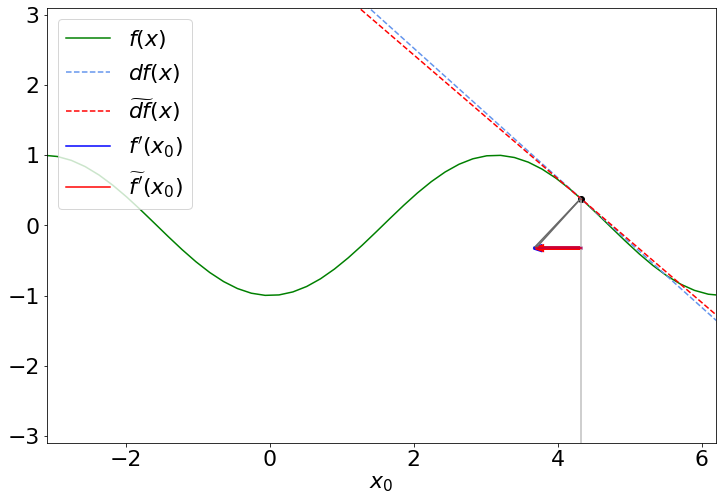

In [ ]:
#@title Double click to unhide/hide the code {run: "auto"}
x_0 = 4.32 #@param {type:"slider", min:-3.1, max:6.2, step:0.01}
batch_size = 1 #@param {type:"slider", min:1, max:256, step:1}

interactive_batch_size_visual(x_0, batch_size)

**Ejercicio:** Que relaciones generales observad entre la precisión del gradiente estimado $\red{\tilde{f'}(x_0)}$ y (a) el tamaÑo del batch y (b) la función $\green{f(x)}$?

### Implementing SGD

Implementar el SGD es muy sencillo. Veamos cómo quedaría para el caso de la función de Rosenbrock. 
EN este caso, no vamos a usar el parámetro states, pero lo incluimos para poder reciclar la función principal cuando agreguemos momentum.

In [ ]:
def SGD_update(x,y, grads, states, hyper_params):
  x.value = x.value - hyper_params['lr']*grads[x]
  y.value = y.value - hyper_params['lr']*grads[y] 
  return x,y,[]

Visualicemos que ocurre en cada paso de SGD (con tamaño de batch =1) para la función de Rosenbrock:



In [ ]:
#@title Helper functions (RUN ME) (double click to unhide/hide the code)
# Esta porción de código define la clase Variable usada para poder hacer una 
# implementación a mano de backpropagation.
from collections import defaultdict
class Variable:
  def __init__(self, value, local_gradients=()):
    self.value = value
    self.local_gradients = local_gradients
  def __add__(self, other):
    "crea una variable que resulta de sumar dos variables."
    return add(self,other)
  def __subtract__(self, other):
    return subtract(self, other)
  def __mult_by_constant(self,const):
    return mult_by_constant(self, const)
  def __square__(self):
    "crea una variable que reulta de elevar al cuadrado otra variable"
    return square(self)
  def __add__(self, other):
    "crea una variable que resulta de sumar dos variables."
    return add(self, other)
# Defino las funciones que necesito para armar la funcion de Rosenbrock
def square(a):
  "crea una variable que reulta de elevar al cuadrado otra variable"
  value = np.power(a.value, 2)
  local_gradients = (
      (a, 2*a.value),) # the local derivative with respect to a is 2a.value
  return Variable(value, local_gradients)
def add(a, b):
  "crea una variable que resulta de sumar dos variables."
  value = a.value + b.value    
  local_gradients = (
    (a, 1),  # the local derivative with respect to a is 1
    (b, 1)   # the local derivative with respect to b is 1
  ) 
  return Variable(value, local_gradients)
def subtract(a,b):
  value = a.value - b.value    
  local_gradients = (
    (a, 1),  # the local derivative with respect to a is 1
    (b, -1)   # the local derivative with respect to b is 1
  ) 
  return Variable(value, local_gradients)
def mult_by_constant(a, constant):
  "crea una variable que resulta de sumar dos variables."
  value = constant*a.value    
  local_gradients = (
    (a, constant),
  ) 
  return Variable(value, local_gradients)

# Defino una funcion que me calcula los gradientes usando bakpropagation y
# la clase Variable antes definida.
def get_gradients(variable):
  """ Compute the first derivatives of `variable` 
  with respect to child variables.
  """
  gradients = defaultdict(lambda: 0)
  
  def compute_gradients(variable, path_value):
      for child_variable, local_gradient in variable.local_gradients:
          # "Multiply the edges of a path":
          value_of_path_to_child = path_value * local_gradient
          # "Add together the different paths":
          gradients[child_variable] += value_of_path_to_child
          # recurse through graph:
          compute_gradients(child_variable, value_of_path_to_child)
  
  compute_gradients(variable, path_value=1)
  # (path_value=1 is from `variable` differentiated w.r.t. itself)
  return gradients

# Defino una función optimize_banana que va a ir actualizando los parameros x,y 
# con SGD y me grafica la evolución

def optimize_banana(update_func, params, hyper_params, epochs, states=(), add_gradient_noise=False):
  "update func: SGD_update,   params: valores iniciales de (x,y),  lr: learning rate"
  # plot the loss surface, minimum value and starting point
  X, Y, Z = gen_2d_loss_surface(rosenbrock_banana)
  fig, ax = make_contour_plot(X, Y, Z)
  ax.plot(1, 1, 'r*', ms=30, label='minimum') 
  ax.plot(start_x, start_y, 'b*', ms=20, label='start')
  x=Variable(params[0])
  y=Variable(params[1])
  for epoch in range(epochs):
    if add_gradient_noise:
      b=30+np.random.normal() 
    else:
      b=30
    old_x = x
    old_y = y
    #armo el grafo de cómputo
    x = Variable(x.value)
    y = Variable(y.value)
    v1 = subtract(Variable(1),x)
    v2 = square(v1)
    v3 = square(x)
    v4 = subtract(y,v3)
    v5 = square(v4)
    v6 = mult_by_constant(v5,b)
    loss = add(v2,v6)
    # calculate the gradients of the loss with respect to the params
    grads = get_gradients(loss)
    # save the old x and y values for the plot
    

    # update the parameters using SGD
    x,y,states = update_func(x,y, grads=grads, states=states, hyper_params=hyper_params)

    # plot the change in x and y for each update step
    ax.annotate('', xy=(x.value, y.value),
                xytext=(old_x.value, old_y.value),
              arrowprops={'arrowstyle': '->', 'color': 'k', 'lw': 1},
                   va='center', ha='center')  

  ax.plot(x.value, y.value, 'g*', ms=20, label='end')
  ax.legend()

  fig.show()
  

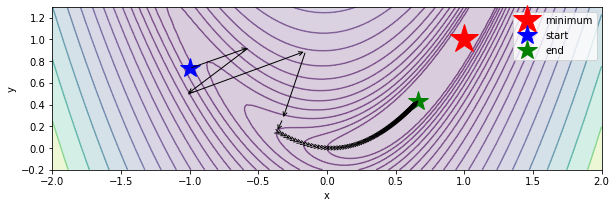

In [ ]:
#@title Double click to unhide/hide the code {run: "auto"}
start_x = -1 #@param {type:"slider", min:-2, max:2, step:0.1}
start_y = 0.73334 #@param {type:"slider", min:-0.26666, max:1.0666, step:0.1}
learning_rate = 0.012 #@param {type:"slider", min:0, max:0.014, step:0.0005}
epochs = 100 #@param {type:"slider", min:1, max:300, step:1}


optimize_banana(SGD_update, params=[start_x,start_y],hyper_params={'lr':learning_rate}, epochs=epochs, add_gradient_noise=False)

**Observación:** En este caso, el gradiene que calculamos es el exacto, ya que conideramos a=1 y b=30 para actualizar los ($x,y$). SI queremos que se parezca más a algo estocástico se puede gregar un ruido al parámetro $b$ de la funci'pn de Rosenbroc. Para ello se puede setear el parámetro <add_gradient_noise=False> que agrega ruido gaussiano de media 0 y varianza 1 a $b$. 

## SGD with Momentum

HTal vez hayas observado un incoveniento con SGD. Cuando el gradiente es muy chico u oscila (i.e. en la region 'banana'), el progreso hacia el mínimo es muy lento. Una solución es agregar momentim a la optimización.

\begin{align}
\mathbf{θ} &= \mathbf{θ} − \gamma \Delta \mathbf{θ}-\eta \nabla_\mathbf{θ} L(\mathbf{θ})
\end{align}

donde $\Delta \mathbf{θ}$ es el cambio en los parámetros entre iteraciones. $\gamma$ (gamma) es término de *momentum*, y $\eta$ sigue siendo la tasa de aprendizaje, o paso.

El término de momentum acelera la optimización si la dirección de cambio se mantiene más o menos la misma y reduce la oscilación cuando la dirección de cambio oscila.

### Implementing Momentum

In [ ]:
def momentum_update(x,y, grads, states, hyper_params):
  # hyper-param typical values: learning_rate=0.01, momentum=0.9
  
  xant = x.value
  yant = y.value
  x.value = x.value + hyper_params['momentum'] * states[0] - hyper_params['lr'] * grads[x]
  y.value = y.value + hyper_params['momentum'] * states[1] - hyper_params['lr'] * grads[y]
  states = [x.value-xant, y.value-yant]
  return x,y, states

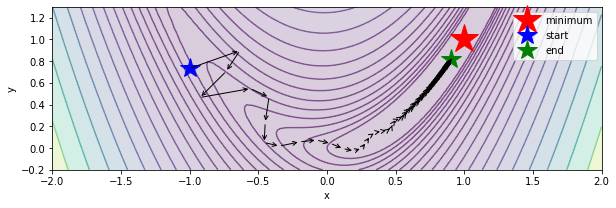

In [ ]:
#@title Double click to unhide/hide the code{run: "auto"}
start_x = -1 #@param {type:"slider", min:-2, max:2, step:0.1}
start_y = 0.73334 #@param {type:"slider", min:-0.26666, max:1.0666, step:0.1}
learning_rate = 0.01 #@param {type:"slider", min:0, max:0.02,step:0.0005}
momentum = 0.7 #@param {type:"slider", min:0, max:0.99, step:0.01}
epochs = 100 #@param {type:"slider", min:1, max:150,step:1}

params = [start_x, start_y]
states = [0,0]
hyper_params = {"lr": learning_rate, "momentum": momentum}


optimize_banana(momentum_update, params=params, epochs=epochs, hyper_params=hyper_params, states=states, add_gradient_noise=True)

**Ejercicio:** Jugar con los hiperparámetros (lr, mometum y epoch) y ver si se alcanza el mínimo. Comparar la performance entre SGD con y sin momentum.

## Extra resources

* A [blog post](http://fa.bianp.net/teaching/2018/eecs227at/gradient_descent.html) from Fabian Pedregosa on gradient descent [**Highly Recommended**].
* [Distil.pub post](https://distill.pub/2017/momentum/) by Gabriel Goh on why momentum works [**Highly Recommended**].
* [Sebastian Ruder's blog](http://ruder.io/optimizing-gradient-descent/) on gradient descent algorithms.
